# **Longhorn Neurotech Week 2 Onboarding - ML Development**

The purpose of this notebook is to familiarize yourself on the basics of machine learning, and how to use relevant libraries in Python.

After this exercise, you should be able to load and manipulate data, and create a basic model that you can use to solve simple regression and classification problems

For our purposes, we do not expect you to understand the mathematical background of many of these topics, but expect to gradually understand **WHAT** certain functions, models, and optimizers are, **HOW** to use them, and **WHY** we use them.

**At the end of this assignment, you will deliver:**
1. **A working (hopefully) classification model that is very good at distinguishing between images of clothing**
2. **Questions to share**
3. **Some insight to give at the next meeting**

## **Intro to ML using Pytorch**

When it comes to machine learning, there are two major types of problems we deal with: **regression** and **classification**

- **Classification**: for a new picture (data point), what **class** does it belong in out of a finite number of **classes**?
  - Example: given a new picture of an animal, does it belong in the **fish class**, the **dog class**, or the **cat class**?
- **Regression**: for a new personal profile (data point), what is its predicted output value? (Think of regression as a classification problem with an *infinite* number of classes)
  - Example: say a person is 30 years old, has 25,000 dollars in student loans, three kids, two cars, and a $83,000 salary. What is their predicted credit score?

In most pytorch pipelines, there are three major steps to consider:

1. Design the model -- input size, output size, forward pass
2. Create loss and optimizer functions
3. Implement the training loop:
  - in the forward pass, compute the prediction and loss
  - in the backward pass analyze the gradients
  - from the analysis, update the weights

Note that this is basically all done for you in the PyTorch package, all you need to understand the the high level organization of these steps

# **EXAMPLE: Linear Regression in Pytorch**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

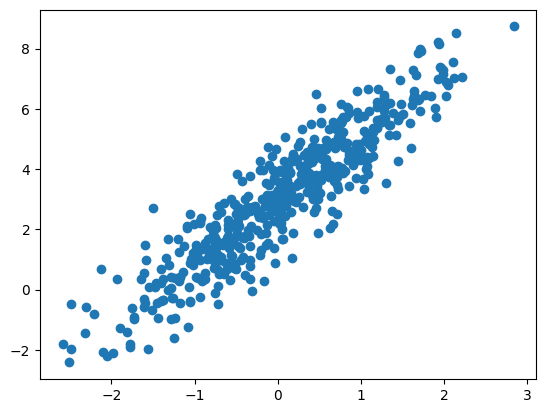

In [ ]:
# Step 1: Data processing

'''
  - here I synthetically generate some data in a linear fashion, do not worry too much about how I do this (because we totally don't make up data in the real world lol)
'''

num_points = 500
num_features = 1

torch.manual_seed(42)
X = torch.randn(num_points, num_features)

noise = 0.9 * torch.randn(num_points, num_features)  # Adding some noise
y = 2 * X + 3 + noise  # Linear relation with noise

plt.scatter(X, y)
plt.show()

In [ ]:
# Step 2: Define a simple linear model

'''
  - The init constructor defines the stacked organization of the model: your model can consist of many different 'sub-models' and activation functions -- more on this later
  - The forward function defines how you input data passes through each layer in what order

  - This example is super simple, we have one nn.Linear layer and we pass the inputs through that nn.Linear layer only
      - (technically we do not need this entire python class, but it is good to remember this as a starting point for more complex models)
'''


class SimpleLinearModel(nn.Module):
    def __init__(self):
        super(SimpleLinearModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # Input = 1 feature, Output = 1 feature

    def forward(self, x):
        return self.linear(x)

In [ ]:
# Step 3: Create model, define loss function and optimizer

# Create an instance of the model
model = SimpleLinearModel()

'''
  - the criterion is how we evaluate the model, i.e. how accurate it is, how much error is there, how much room for improvement do we have?
  - there are many ways to evaluate a model (finding the loss): for linear regression, a popular evaluator is Mean Squared Error, here is a wikipedia link about it: https://en.wikipedia.org/wiki/Mean_squared_error
'''

criterion = nn.MSELoss()  # Mean Squared Error Loss for regression


'''
  - the optimizer is how we update the model to make it worse or better
  - in the context of the criterion we just defined, what we will do is that
      - FOR a number of iterations, we input our training data into a model, evaluate the performance using the criterion, then update the weights using the optimizer
  - there are various different optimization algorithms
      - SGD stands for Stochastic Gradient Descent -- this is very advanced for this topic, but you can read about it here: https://en.wikipedia.org/wiki/Stochastic_gradient_descent
'''

optimizer = optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent, with a learning rate of 0.01


In [ ]:
# Step 4: Train the model

num_epochs = 200 # this is the number of iterations we will do the training loop for

# Training loop
for epoch in range(num_epochs):

    # reset the gradients so the weights from the previous iteration do not affect this one
    optimizer.zero_grad()

    # Forward pass: Compute predicted y by passing X to the SimpleLinearModel model
    y_pred = model(X)

    # Compute loss
    loss = criterion(y_pred, y)

    # Backward pass: Compute gradients
    # the backward() function goes backward through the pipeline we defined in the forward pass, and computes the gradient of each weight at each stage of the model
      # the gradient is a measure of how much a particular feature or layer contributes to the model performance: these are adjusted to incrementally make the model better
    loss.backward()

    # NOTE: the loss is stored globally, so if you stop the function, the loss will pick up where it was left off

    # Update weights
    optimizer.step()

    # Print loss every 20 epochs
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [20/200], Loss: 10.1566
Epoch [40/200], Loss: 4.8626
Epoch [60/200], Loss: 2.5496
Epoch [80/200], Loss: 1.5390
Epoch [100/200], Loss: 1.0975
Epoch [120/200], Loss: 0.9046
Epoch [140/200], Loss: 0.8203
Epoch [160/200], Loss: 0.7835
Epoch [180/200], Loss: 0.7674
Epoch [200/200], Loss: 0.7603


In [ ]:
# Step 5: Evaluate the model
# Get predictions and print the final model parameters (slope and intercept)
with torch.no_grad():
    predicted = model(X)
    print(f'Final Parameters: {model.linear.weight.item():.2f} (slope), {model.linear.bias.item():.2f} (intercept)') # these values should be close to the ground truth defined in the first cell


Final Parameters: 2.02 (slope), 2.92 (intercept)


At this point, you should be able to:

- define what loss, optimizers, forward pass, and backward pass is/are
- be able to create and train a model with a Linear layer in one input dimension
- be able to quantify, plot, and demonstrate the performance of your model

# **EXERCISE: Classification in Pytorch**

Now that we have a general framework of how to build a model, we will do the same with a classification problem

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Here, I am loading the MNIST-Fashion dataset -- this is similar to the MNIST set of handwritten digits, but this is for 10 classes of clothing articles like shoes, trousers, pullovers, etc

Some important terminology to know:
  - a *transform* is a data manipulation framework. There are many things you can do inside a transform, here the transform is waiting to convert data to a *tensor* and *normalize* it
    - a *tensor* is a fancy word for a special PyTorch array/matrix, the behavior is the same as regular arrays, but they are optimized for PyTorch
    - *normalizing* usually means that we take the values of our data and represent them with equal or random weight. This is to ensure that no one feature has a greater impact on the output than another. Here we need to consider that each pixel is represented on a grayscale, so we want to normalize each pixel according to a gaussian curve with mean and standard deviation 0.5
    


  - a *data loader* can be seen as an intermediary step in between actually putting your data into your model. Having a dataloader can speed up model processing, and give some cool features like shuffling your data.
    - TLDR: loop over the dataloader instead of the data itself, and good things happen :)

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean=0.5 and std=0.5
])

# Load the Fashion-MNIST datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders for training and testing
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)


Now lets define our model architecture!

We are gonna define a fairly advanced model based on a convolutional neural network (CNN), so take some time to research (use ChatGPT) and understand each part of this. Understanding this part is crucial to what we will be doing moving forward. I will give a high level instruction of what to do, and you can copy and paste each step into ChatGPT to learn more about it, and what to write for that step.

I started with the class stem and implementing the forward function, this will be the blank canvas for our model

**In the init__ constructor:**
1. (*done for you*) add a convolutional 2d layer with 1 input channel, 16 output channels, and a 3x3 kernel
2. add a second convolutional 2d layer with 16 input channels, 32 output channels, and a 3x3 kernel
3. create a max pooling 2d layer with a 2x2 filter and a kernel size of 2
4. create a fully connected Linear layer to flatten an input vector of 32 * 7 * 7 to 128
5. create one more fully connected Linear layer that takes an input vector size of 128 and outputs a vector of probabilities of length 10


**In the forward pass function**
1. (*done for you*) send x through the **first convolutional layer** -> send that through a **torch.relu()** activation function -> **pool** the results
2. send x through the **second convolutional layer** -> send that through a **torch.relu()** activation function -> **pool** the results
3. flatten x to a single dimension vector using x.view(-1, 32 * 7 * 7)
4. send x through the **first fully connected Linear** layer -> send that through a **torch.relu()** activation function
5. finally, send x through the **second fully connected Linear** layer.

After the last step, we should get a tensor of length 10, each value corresponds to a probability that the input image is that corresponding label

In [ ]:
class FashionMNIST_CNN(nn.Module):
  def __init__(self):
    super(FashionMNIST_CNN, self).__init__()

    # add layers here -- Replace each "None" with the layer code
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1) # convolutional 2d layer with 1 input channel, 16 output channels, and a 3x3 kernel

    self.conv2 = None

    self.pool = None

    self.fc1 = None

    self.fc2 = None

  def forward(self, x):

    # connect the layers here in the forward pass

    # send x through the first convolutional layer
    x = self.conv1(x)

    # send that through a torch.relu() activation function
    x = torch.relu(x)

    # pool the results
    x = self.pool(x)



    # continue here...


    return x


Do not worry if you don't know everything that is going on! This is a lot, but the best way to learn is by doing, so lets keep on *doing* and we can tackle actually understanding the model in discussion later!

The next thing we have to do is
1. Instantiate our CNN model
2. Define our loss function (use nn.CrossEntropyLoss())
3. Define an optimizer (use optim.Adam()), load the model parameters and set the learning rate to 0.001

In [ ]:
# instantiate the model

# define the loss function/criterion

# define the adam optimizer


Now the fun step, we will write the training loop! Be sure to refer back to the example above, but there are a few more things we will add to make this more robust since the MNIST set is much larger and more complex. Here is the pseudocode for the training algorithm

1. define a number of epochs (iterations). 5 is a good number for now
2. create a training for loop over each epoch
  3. set the model to be in training mode using "model.train()"
  4. set a variable called "total_running_loss" for each epoch to 0.0
  5. make a nested for loop, this one will iterate over each image and label in the train_loader
    6. reset the gradients to zero
    7. compute the predicted y (labels) by running the images through the model
    8. compute your loss
    9. do a backwards pass and compute the gradients on your loss
    10. update the weights using the optimizer
    11. add the current loss.item() to the total running loss
  12. print the total running loss for each epoch to observe progress

We should observe that the loss decreases every epoch. Running this loop might take a few minutes.

In [ ]:
# Write the training loop



At this point, your model should be fully trained! Here is a function that will evaluate the accuracy of your model using the test set. You may need to change the model name to match what you named your's. Take some time to understand this

In [ ]:
# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for faster inference
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

# Evaluate the model on the test set, CHANGE THE MODEL NAME HERE IF IT IS DIFFERENT
evaluate_model(model, test_loader)


Accuracy of the model on the test images: 91.34%


**Bonus**: If you're like me, seeing a good model accuracy isn't satisfying enough. Figure out a way to visually check your model. Get a picture from the set, run it through the model, and compare the expected output and the output of your model. Do they match up?